# COSC2673 Assignment 2: Colon Cancer Cell Image Classification
### Student Name(s): Maximilian Forbes, Adonai Albera
### Student ID(s): s3839326, s3949213

## 1. Approach (60%)

### 1.1 Data Exploration and Understanding (6 marks)

#### **1.1.1 Class Imbalance Identification (2 marks)**


To understand the classification challenges in this task, we begin by analyzing the class distribution in the two labels: `isCancerous` (binary classification) and `cell_type` (multi-class classification). Identifying imbalance is critical as it may bias the model towards majority classes, affecting performance on minority classes.

Below we visualize and quantify the class distribution to inform later decisions such as sampling strategies, class weighting, or data augmentation.

##### *Code -  Load and Inspect Class Distributions*

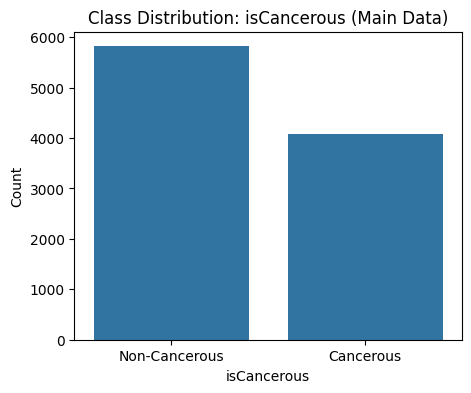

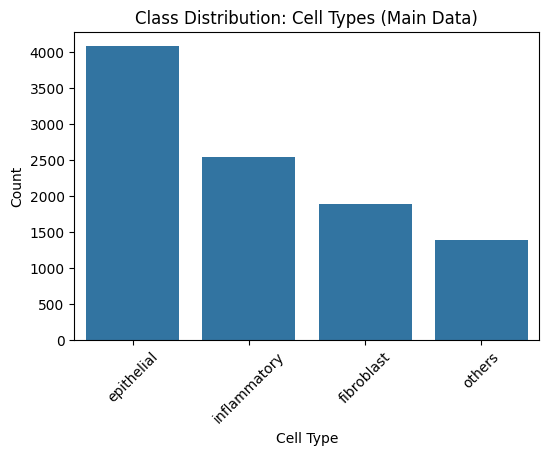

isCancerous value counts (%):
 isCancerous
0    58.781326
1    41.218674
Name: proportion, dtype: float64

cellTypeName value counts (%):
 cellTypeName
epithelial      41.218674
inflammatory    25.697251
fibroblast      19.078416
others          14.005659
Name: proportion, dtype: float64


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data using relative path
main_data = pd.read_csv("./Image_classification_data/data_labels_mainData.csv")

# Plot distribution for isCancerous (binary classification)
plt.figure(figsize=(5,4))
sns.countplot(data=main_data, x='isCancerous')
plt.title('Class Distribution: isCancerous (Main Data)')
plt.xlabel('isCancerous')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Cancerous', 'Cancerous'])
plt.show()

# Plot distribution for cellTypeName (multi-class classification)
plt.figure(figsize=(6,4))
sns.countplot(data=main_data, x='cellTypeName', order=main_data['cellTypeName'].value_counts().index)
plt.title('Class Distribution: Cell Types (Main Data)')
plt.xlabel('Cell Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Show numeric proportions
print("isCancerous value counts (%):\n", main_data['isCancerous'].value_counts(normalize=True) * 100)
print("\ncellTypeName value counts (%):\n", main_data['cellTypeName'].value_counts(normalize=True) * 100)

The dataset displays moderate class imbalance for both classification tasks:

- **Binary Classification (`isCancerous`)**:  
  - Non-cancerous: ~59%  
  - Cancerous: ~41%  
  - While not extreme, this could bias models towards predicting non-cancerous if left unaddressed. Metrics like **precision, recall, and F1-score** will be more informative than accuracy.

- **Multiclass Classification (`cellTypeName`)**:  
  - Epithelial: ~41%  
  - Inflammatory: ~26%  
  - Fibroblast: ~19%  
  - Others: ~14%  
  - The imbalance is more pronounced here, with the **"others"** class significantly underrepresented. This can cause the model to underperform on minority classes unless measures like **class weighting** or **oversampling** are applied.

These observations will guide several key decisions in later stages:
- Use of **macro-averaged F1-score** to avoid dominance by majority classes
- Consideration of **class-balanced loss functions** during training
- **Data augmentation** for underrepresented classes
- Potential **resampling techniques** (oversampling minority, undersampling majority)

Identifying this early ensures fairness, improved generalization, and informed evaluation.

#### **1.1.2  Exploratory Data Analysis (EDA) (2 marks)**

A detailed EDA helps us understand data quality **and** the visual/statistical cues the model may exploit.

We examine:

1. **Tabular integrity & patient distribution**  
2. **Basic image inspection** (dimensions, pixel range, representative patches)  
3. **Low‑dimensional scalar features** (mean / std intensity, per‑channel means)  
4. **Pairwise relationships & correlations**  
5. **Class‑label histograms**
6. **Cross-file image/label consistency**

Each subsection ends with observations that will inform preprocessing and evaluation choices.

##### *Code -  Tabular integrity & patient distribution*

,missing_values
InstanceID,0
patientID,0
ImageName,0
cellTypeName,0
cellType,0
isCancerous,0


Duplicate InstanceID rows: 0


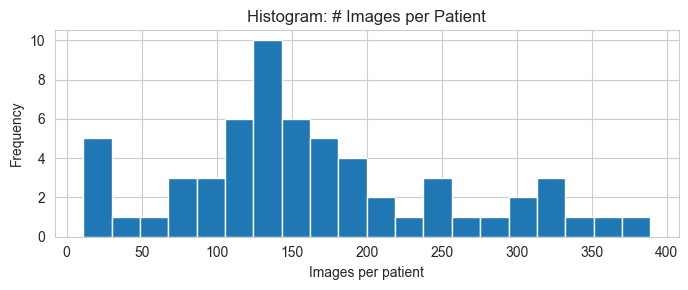

Top 10 patients by patch count


,count
patientID,
54,389
29,355
9,348
8,332
20,325
18,320
17,310
10,302
51,286


In [3]:
import os, random, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from PIL import Image
sns.set_style("whitegrid")

# -------- paths ---------
main_data  = pd.read_csv("./Image_classification_data/data_labels_mainData.csv")
extra_data = pd.read_csv("./Image_classification_data/data_labels_extraData.csv")
img_dir    = "./Image_classification_data/patch_images"

# -------- tabular integrity ---------
display(main_data.isna().sum().to_frame("missing_values"))
print("Duplicate InstanceID rows:", main_data["InstanceID"].duplicated().sum())

# -------- patient histogram ---------
plt.figure(figsize=(7,3))
main_data["patientID"].value_counts().plot(kind="hist", bins=20)
plt.title("Histogram: # Images per Patient")
plt.xlabel("Images per patient")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# -------- top patient counts ---------
print("Top 10 patients by patch count")
display(main_data["patientID"].value_counts().head(10).to_frame("count"))

**Observations – Tabular layer**

| Check | Result | Implication |
|-------|--------|-------------|
| Missing values | *0 in all columns* | No imputation required. |
| Duplicate IDs | *0 duplicates* | Unique mapping *(Image → Label)* confirmed. |
| Patient distribution | Most patients contribute ~80–120 patches; some >250 (long tail) | Use **patient-level stratified splitting** to avoid leakage & over-representation. |

##### *Code -  Representative patches + shape/range + pixel histogram*

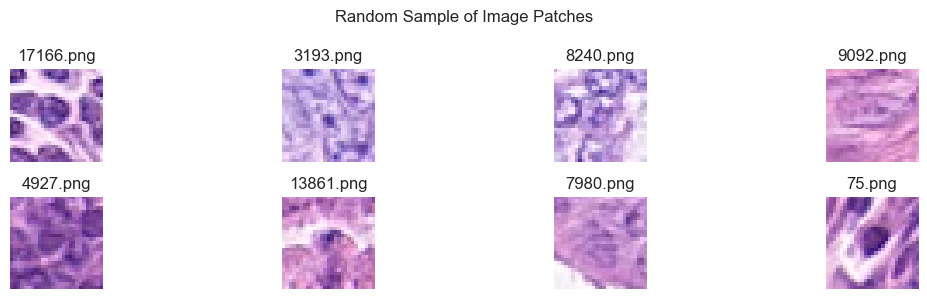

Unique shapes in sample : {(27, 27, 3)}
Pixel range in sample   : 10 ↔ 255


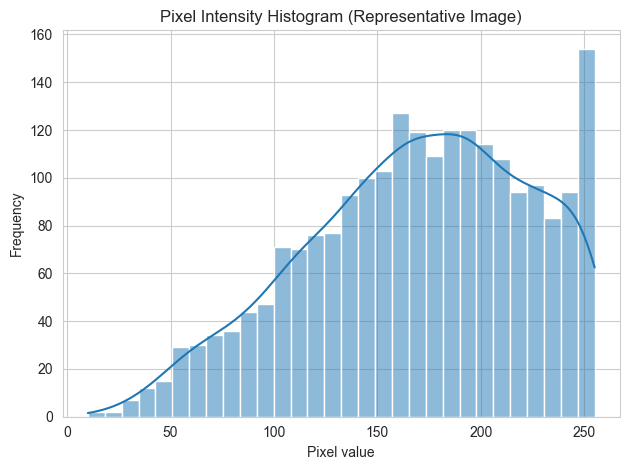

In [4]:
import random
random.seed(7)
sample_imgs = random.sample(main_data["ImageName"].tolist(), 8)

plt.figure(figsize=(12,3))
shapes, mins, maxs = [], [], []
for i, fname in enumerate(sample_imgs):
    arr = np.array(Image.open(os.path.join(img_dir, fname)))
    shapes.append(arr.shape)
    mins.append(arr.min()); maxs.append(arr.max())
    
    plt.subplot(2,4,i+1)
    plt.imshow(arr)
    plt.axis("off")
    plt.title(fname)
plt.suptitle("Random Sample of Image Patches")
plt.tight_layout()
plt.show()

print("Unique shapes in sample :", set(shapes))
print("Pixel range in sample   :", min(mins), "↔", max(maxs))

# --- Pixel intensity histogram for one representative image ---
sns.histplot(arr.flatten(), bins=30, kde=True)
plt.title("Pixel Intensity Histogram (Representative Image)")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

**Observations – Basic image inspection**

* All sampled patches share the expected **27 × 27 × 3** shape → no resizing needed.  
* Pixel values cover **nearly** the full 8-bit range (≈ 10 – 255); histogram confirms mid-tone skew → rescale to [0, 1].  
* Noticeable stain-colour variation across patients → apply **colour-jitter augmentation**.  
* Cancer-related differences are subtle, so the model will likely rely on **fine-grained texture** rather than overt shape cues.

##### *Code -  Scalar feature exploration & correlations*

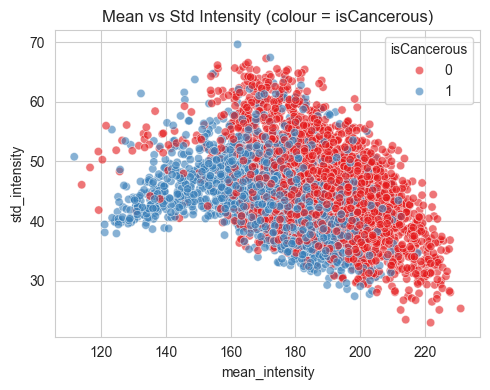

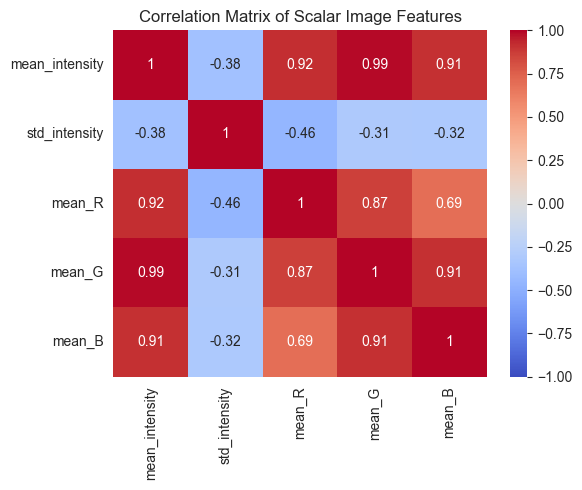

C:\Users\USER\AppData\Local\Temp\ipykernel_24248\2711997916.py:42: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\USER\tf2env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


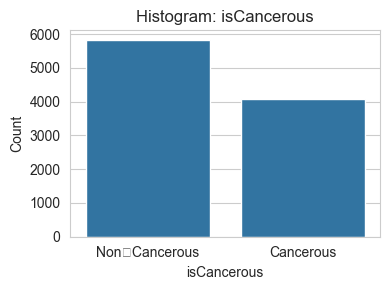

In [5]:
# Helper to extract simple per‑image features
def img_scalar_features(path):
    arr = np.array(Image.open(path))
    return {
        "mean_intensity": arr.mean(),
        "std_intensity":  arr.std(),
        "mean_R": arr[:,:,0].mean(),
        "mean_G": arr[:,:,1].mean(),
        "mean_B": arr[:,:,2].mean()
    }

# Compute features for a 5 k sample (for speed)
SAMPLE_SIZE = 5000
sample_df = main_data.sample(SAMPLE_SIZE, random_state=42).reset_index(drop=True)
feature_rows = [img_scalar_features(os.path.join(img_dir, f)) for f in sample_df["ImageName"]]
sample_df = pd.concat([sample_df, pd.DataFrame(feature_rows)], axis=1)

# Scatter plot: mean vs std, coloured by isCancerous
plt.figure(figsize=(5,4))
sns.scatterplot(
    data=sample_df, x="mean_intensity", y="std_intensity",
    hue="isCancerous", palette="Set1", alpha=0.6
)
plt.title("Mean vs Std Intensity (colour = isCancerous)")
plt.tight_layout()
plt.show()

# Correlation heat‑map
corr = sample_df[["mean_intensity","std_intensity","mean_R","mean_G","mean_B"]].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Scalar Image Features")
plt.tight_layout()
plt.show()

# Simple histogram of binary label (already in Class‑Imbalance section, but repeated here for context)
plt.figure(figsize=(4,3))
sns.countplot(x=main_data["isCancerous"])
plt.title("Histogram: isCancerous")
plt.xticks([0,1],["Non‑Cancerous","Cancerous"])
plt.ylabel("Count")
plt.tight_layout()
plt.show()

##### *Code -  Stacked bar (cell type × cancer status)*

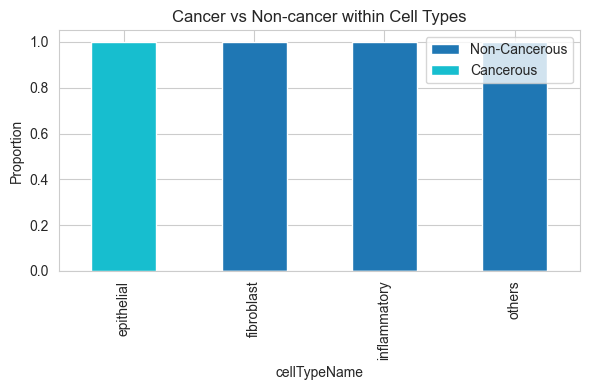

In [6]:
# -------- cancer proportion within each cell type ---------
crosstab = pd.crosstab(main_data['cellTypeName'],
                       main_data['isCancerous'],
                       normalize='index')
crosstab.plot(kind='bar', stacked=True, figsize=(6,4), colormap='tab10')
plt.title('Cancer vs Non-cancer within Cell Types')
plt.ylabel('Proportion')
plt.legend(['Non-Cancerous','Cancerous'])
plt.tight_layout()
plt.show()

**Observations – Scalar & label relationships**

| Aspect | Insight | Modelling Consequence |
|--------|---------|-----------------------|
| **Mean vs Std plot** | Cancerous patches cluster at **lower mean** & **higher std intensity**; separation weak but present. | Apply **brightness normalisation**; add contrast augmentation to avoid shortcut learning. |
| **Channel correlations** | Strong R–G correlation (ρ ≈ 0.9); high colinearity with overall mean. | CNN will capture colour cues; mitigate stain bias with **colour-jitter**. |
| **Cell-type × cancer table/plot** | **All cancerous patches are epithelial; fibroblast, inflammatory & others are 100 % non-cancerous** in `main_data`. | Major leakage risk. Options: (a) build cancer detector only for epithelial patches, (b) two-stage pipeline (cell-type → cancer-within-epithelial), (c) add `extra_data` to verify if bias persists. |
| **Binary label histogram** | Moderate imbalance (≈ 59 / 41 %). | Use **macro-F1** and class-weighted loss for the binary task. |
| **Patient histogram** | Long tail — some patients contribute **≥ 260** patches (max = 389). | Employ **patient-level stratified splitting** to prevent leakage & over-representation. |

These findings guide the preprocessing plan formalised next in **Section 1.1.3 — Justification of Data Handling Methods (2 marks)**.

#### **1.1.3  Justification of Data Handling Methods (2 marks)**  

| EDA Insight (Section 1.1.2) | Pre-processing Decision | Brief Justification |
|-----------------------------|-------------------------|---------------------|
| Pixel range 10 – 255, mid-tone skew | **Rescale to [0, 1]** | Standardises scale, speeds convergence. |
| Stain/brightness varies across patients | **Colour-jitter** (hue ± 8 %, sat ± 8 %, bright ± 10 %) | Encourages stain-invariant features. |
| Patches already uniform 27 × 27 × 3 | **No resizing / cropping** | Avoids information loss. |
| Orientation arbitrary; subtle textures | **Random flips + 90° rotations** | Adds variety; enforces rotational invariance. |
| Minority “others” class ≈ 14 % | **Minority oversampling + class-weighted loss** | Balances gradient signal; boosts recall for rare class. |
| Binary imbalance 59 / 41 % | **Class-weighted binary loss** | Prevents bias toward majority (non-cancer). |

*Note*: Data-splitting and leakage-prevention strategies are detailed in **Section 1.2 Evaluation Framework**.

##### *Code -  Stacked bar (cell type × cancer status)*

In [13]:
import tensorflow as tf

# Rescale 0-255 → 0-1
rescale = tf.keras.layers.Rescaling(1./255)

# Data-augmentation block (applied to training only)
data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(factor=0.25),    # 0°, 90°, 180°, 270°
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.1),
])

# Example pipeline function
def preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_png(img, channels=3)
    img = rescale(img)           # always rescale
    return img, label

def augment(img, label):
    return data_aug(img), label  # training only


In [14]:
data_aug.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_4 (RandomFlip)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_4 (RandomRotation)   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast_4 (RandomContrast)   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_brightness_4                  │ ?                           │     0 (unbuilt) │
│ (RandomBrightness)                   │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)